# Fetchting Data

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mdshajibhossain","key":"3fa12b17efb1c7297f030a9dcfe286c7"}'}

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# https://www.kaggle.com/datasets/mdriazul/pv-tomato-leaf-disease-augmented-train-val
# kaggle datasets download -d mdriazul/pv-tomato-leaf-disease-augmented-train-val

# https://www.kaggle.com/datasets/mdriazul/pv-tomato-leaf-disease-augmented
# kaggle datasets download -d mdriazul/pv-tomato-leaf-disease-augmented

# https://www.kaggle.com/datasets/mdriazul/pvtomatoleafdisease
# kaggle datasets download -d mdriazul/pvtomatoleafdisease

!kaggle datasets download -d mdriazul/pvtomatoleafdisease --unzip

 93% 233M/250M [00:02<00:00, 107MB/s]
100% 250M/250M [00:02<00:00, 92.1MB/s]


# Spliting the data in train(70%) vlaid and test

In [ ]:
!pip install split-folders[full]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

input_folder = '/content/PlantVillage'

#ratio of split is 70%, 20% and 10%
splitfolders.ratio(input_folder, output="dataset", 
                   seed=42, ratio=(.7, .2, .1), 
                   group_prefix=None)

Copying files: 16012 files [00:02, 5383.21 files/s]


# Importing libraries

In [ ]:
import numpy as np 
import pandas as pd 
from PIL import Image 
import pathlib
import matplotlib.pyplot as plt
import cv2 as cv
import os
import seaborn as sns
import time


import tensorflow as tf
!pip install tensorflow-addons
import tensorflow_addons as tfa

import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.2 MB/s eta 0:00:00


In [ ]:
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=a2c16a16765b8c007f668eda780ac3c51846ad44a4d3d9c808db533752fab118
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built sklearn


# set directory

In [ ]:
IMG_WIDTH=224
IMG_HEIGHT=224
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 32
IMG_DIR = pathlib.Path('/content/dataset')
TRAIN_DIR = '/content/dataset/train'
VAL_DIR = '/content/dataset/val'
TEST_DIR='/content/dataset/test'

# Image data generator


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.pyplot import imread, imshow, subplots, show

def plot(data_generator):
    """
    Plots 4 images generated by an object of the ImageDataGenerator class.
    """
    data_generator.fit(images)
    image_iterator = data_generator.flow(images)
    
    # Plot the images given by the iterator
    fig, rows = subplots(nrows=1, ncols=4, figsize=(18,18))
    for row in rows:
        row.imshow(image_iterator.next()[0].astype('int'))
        row.axis('off')
    show()
    
#image = imread("image.jpeg")

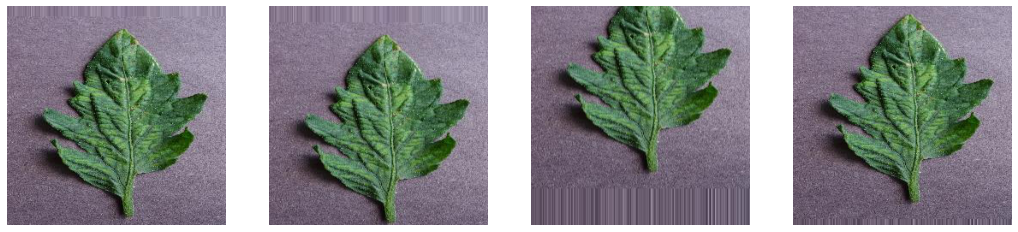

In [ ]:
image = imread("/content/dataset/val/Tomato__Tomato_mosaic_virus/0f47e5f6-7271-45c8-8364-e962dedd83c9___PSU_CG 2148.JPG")
images = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

data_generator = ImageDataGenerator(width_shift_range=0.2)
plot(data_generator)

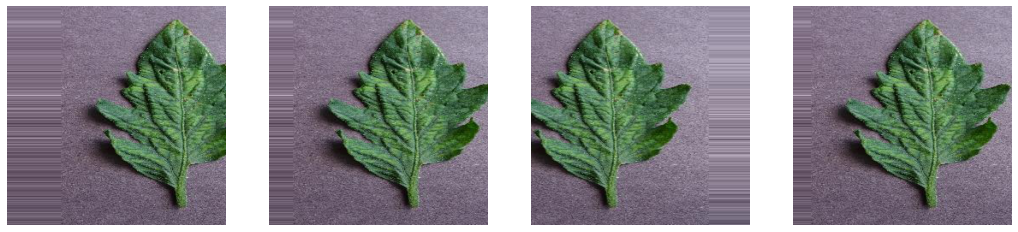

In [ ]:
data_generator = ImageDataGenerator(height_shift_range=0.2)
plot(data_generator)

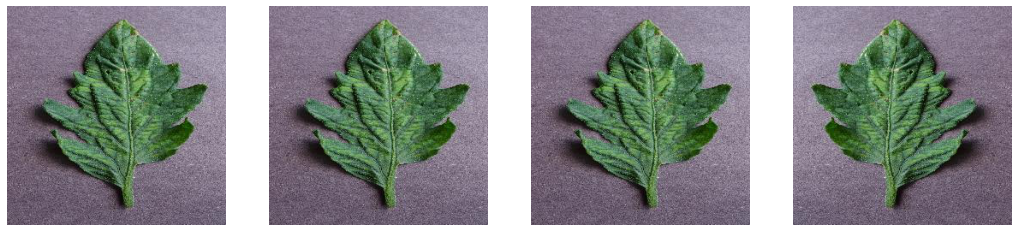

In [ ]:
data_generator = ImageDataGenerator(horizontal_flip=True)
plot(data_generator)

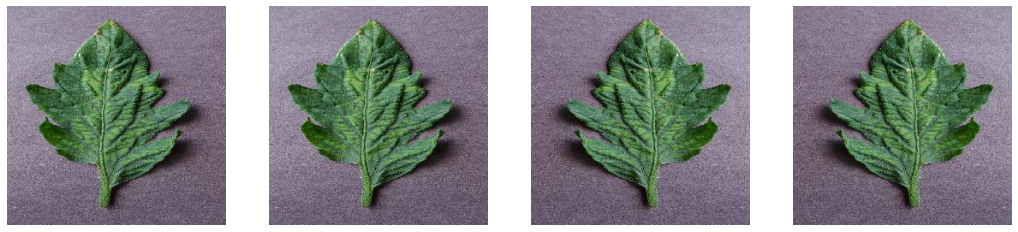

In [ ]:
data_generator = ImageDataGenerator(vertical_flip=True)
plot(data_generator)

In [ ]:
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)
data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                              horizontal_flip = True,
                                              width_shift_range = 0.2,
                                              height_shift_range = 0.2
                                                )

In [ ]:
train_generator = data_generator_with_aug.flow_from_directory(
                                        directory=TRAIN_DIR,
                                        target_size=IMG_DIM,batch_size=BATCH_SIZE,
                                        class_mode='categorical')


validation_generator = data_generator_no_aug.flow_from_directory(
                                        directory=VAL_DIR,
                                        target_size=IMG_DIM,batch_size=BATCH_SIZE,
                                        class_mode='categorical')


test_generator = data_generator_no_aug.flow_from_directory(
                                        directory=TEST_DIR,
                                        target_size=IMG_DIM,batch_size=BATCH_SIZE,
                                        class_mode='categorical')

Found 11203 images belonging to 10 classes.
Found 3198 images belonging to 10 classes.
Found 1610 images belonging to 10 classes.


# Create model

In [ ]:
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3))

output = resnet.layers[-1].output
output = tf.keras.layers.GlobalAveragePooling2D()(output)# use global average pooling
resnet = Model(resnet.input, output)



94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
#just cheking the layers and max pol()
res_name = []
for layer in resnet.layers:
    res_name.append(layer.name)
res_name[-10:] #last er 10 layers er jonno

['conv5_block3_1_bn',
 'conv5_block3_1_relu',
 'conv5_block3_2_conv',
 'conv5_block3_2_bn',
 'conv5_block3_2_relu',
 'conv5_block3_3_conv',
 'conv5_block3_3_bn',
 'conv5_block3_add',
 'conv5_block3_out',
 'global_average_pooling2d']

In [ ]:
set_trainable = False
for layer in resnet.layers:
        layer.trainable = False

In [ ]:
#just cheking the layers and max pol()
res_name = []
for layer in resnet.layers:
    res_name.append(layer.name)
res_name[-50:] #last er 50 layers er jonno

['conv4_block5_2_conv',
 'conv4_block5_2_bn',
 'conv4_block5_2_relu',
 'conv4_block5_3_conv',
 'conv4_block5_3_bn',
 'conv4_block5_add',
 'conv4_block5_out',
 'conv4_block6_1_conv',
 'conv4_block6_1_bn',
 'conv4_block6_1_relu',
 'conv4_block6_2_conv',
 'conv4_block6_2_bn',
 'conv4_block6_2_relu',
 'conv4_block6_3_conv',
 'conv4_block6_3_bn',
 'conv4_block6_add',
 'conv4_block6_out',
 'conv5_block1_1_conv',
 'conv5_block1_1_bn',
 'conv5_block1_1_relu',
 'conv5_block1_2_conv',
 'conv5_block1_2_bn',
 'conv5_block1_2_relu',
 'conv5_block1_0_conv',
 'conv5_block1_3_conv',
 'conv5_block1_0_bn',
 'conv5_block1_3_bn',
 'conv5_block1_add',
 'conv5_block1_out',
 'conv5_block2_1_conv',
 'conv5_block2_1_bn',
 'conv5_block2_1_relu',
 'conv5_block2_2_conv',
 'conv5_block2_2_bn',
 'conv5_block2_2_relu',
 'conv5_block2_3_conv',
 'conv5_block2_3_bn',
 'conv5_block2_add',
 'conv5_block2_out',
 'conv5_block3_1_conv',
 'conv5_block3_1_bn',
 'conv5_block3_1_relu',
 'conv5_block3_2_conv',
 'conv5_block3_2_b

In [ ]:
set_trainable = False
for layer in resnet.layers:
    if layer.name in res_name[-50:]:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
num_classes = 10

model = Sequential()
model.add(resnet)
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 26,215,818
Trainable params: 19,578,634
Non-trainable params: 6,637,184
_________________________________________________________________


In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics=['accuracy',tfa.metrics.F1Score(num_classes=num_classes)])

# Customize call back function


In [ ]:
class ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print('enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training     
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)

In [ ]:
epochs=20
ask_epoch=5
ask=ASK(model, epochs,  ask_epoch)
# rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5,verbose=1,min_delta=5*1e-3,min_lr = 5*1e-7)
early_stop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=1,restore_best_weights=True,min_delta=0.001)
checkpoint = tf.keras.callbacks.ModelCheckpoint('Base_Resnet50v1.01_30epoch.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.2,
                                   patience=4,
                                   verbose=1,
                                   min_delta=5*1e-3,min_lr = 5*1e-7,
                                   )
# lr=tf.keras.callbacks.LearningRateScheduler(scheduler)
# callbacks=[checkpoint, ask,lr]
# callbacks=[checkpoint]

In [ ]:
!nvidia-smi

Mon Jan 16 21:11:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    27W /  70W |    566MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:



model.fit(train_generator,
          epochs = 20,callbacks=[early_stop,reduce_lr],
          validation_data = validation_generator)

Epoch 1/20
351/351 [==============================] - 180s 512ms/step - loss: 2.4056 - accuracy: 0.1375 - f1_score: 0.1146 - val_loss: 2.0191 - val_accuracy: 0.3283 - val_f1_score: 0.2083 - lr: 1.0000e-06
Epoch 2/20
351/351 [==============================] - 167s 475ms/step - loss: 2.0012 - accuracy: 0.3138 - f1_score: 0.2263 - val_loss: 1.6950 - val_accuracy: 0.5041 - val_f1_score: 0.3470 - lr: 1.0000e-06
Epoch 3/20
351/351 [==============================] - 166s 473ms/step - loss: 1.7114 - accuracy: 0.4526 - f1_score: 0.3215 - val_loss: 1.4250 - val_accuracy: 0.6144 - val_f1_score: 0.4439 - lr: 1.0000e-06
Epoch 4/20
351/351 [==============================] - 165s 471ms/step - loss: 1.4827 - accuracy: 0.5419 - f1_score: 0.3967 - val_loss: 1.2088 - val_accuracy: 0.6848 - val_f1_score: 0.5122 - lr: 1.0000e-06
Epoch 5/20
351/351 [==============================] - 165s 470ms/step - loss: 1.2841 - accuracy: 0.6137 - f1_score: 0.4728 - val_loss: 1.0272 - val_accuracy: 0.7273 - val_f1_score:

In [ ]:
model.save("Base_Resnet50v1.01_2epoch.h5")

# Accurancy and Valid Loss count

Text(0, 0.5, 'F1 Score')

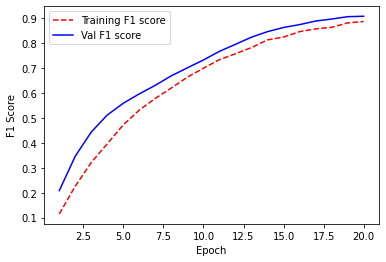

In [ ]:
f1_score_history = model.history.history['f1_score']
f1_scores = [np.mean(item) for item in  f1_score_history]
f1_score_val_hist = model.history.history['val_f1_score']
f1_scores_val = [np.mean(item) for item in  f1_score_val_hist]
training_loss = f1_scores
test_loss = f1_scores_val

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training F1 score', 'Val F1 score'])
plt.xlabel('Epoch')
plt.ylabel('F1 Score')

In [ ]:

def get_diagnostic_plot(model,name):
    training_loss = model.history.history[name]
    test_loss = model.history.history[f'val_{name}']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend([f'Training {name}', f'Val {name}'])
    plt.xlabel('Epoch')
    plt.ylabel(name)

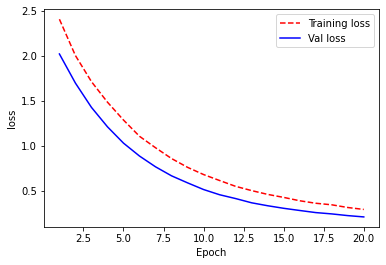

In [ ]:

get_diagnostic_plot(model,'loss')

In [ ]:
import seaborn as sns
import numpy as np
from  sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [ ]:
#Y_pred = model.predict_generator(test_generator, number_of_test_samples // BATCH_SIZE+1)
#y_pred_matrix = np.argmax(Y_pred, axis=1)
y_pred=model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

cm=confusion_matrix(test_generator.classes, y_pred)
print(cm)
print('Classification Report')
order=['BACTERIAL SPOT','EARLY BLIGHT','HEALTHY','LATE BLIGHT','LEAF MOLD',
       'SEPTORIA LEAF SPOT','SPIDER MITE','TARGET SPOT','MOSAIC VIRUS','YELLOW LEAF CURL VIRUS']
#target_names = ['Cats', 'Dogs', 'Horse']
print(classification_report(test_generator.classes, y_pred, target_names=order))

51/51 [==============================] - 7s 123ms/step
[[28 12 29 11 28 17 27 36  6 20]
 [12  4 12  5 16 12  6 22  3  8]
 [25  8 25 14 32 20 11 29  8 20]
 [17  3  8  3  9 10 11 29  0  6]
 [24 13 19 10 21 15 10 42  3 21]
 [22 10 26 15 17 15 15 32  3 13]
 [19  7 16  5 11 20 14 31  4 15]
 [39 13 31 16 55 23 27 73  2 43]
 [ 4  0  7  1  7  6  6  4  0  3]
 [18  4 21 14 20 20 18 26  2 17]]
Classification Report
                        precision    recall  f1-score   support

        BACTERIAL SPOT       0.13      0.13      0.13       214
          EARLY BLIGHT       0.05      0.04      0.05       100
               HEALTHY       0.13      0.13      0.13       192
           LATE BLIGHT       0.03      0.03      0.03        96
             LEAF MOLD       0.10      0.12      0.11       178
    SEPTORIA LEAF SPOT       0.09      0.09      0.09       168
           SPIDER MITE       0.10      0.10      0.10       142
           TARGET SPOT       0.23      0.23      0.23       322
          MOSAI

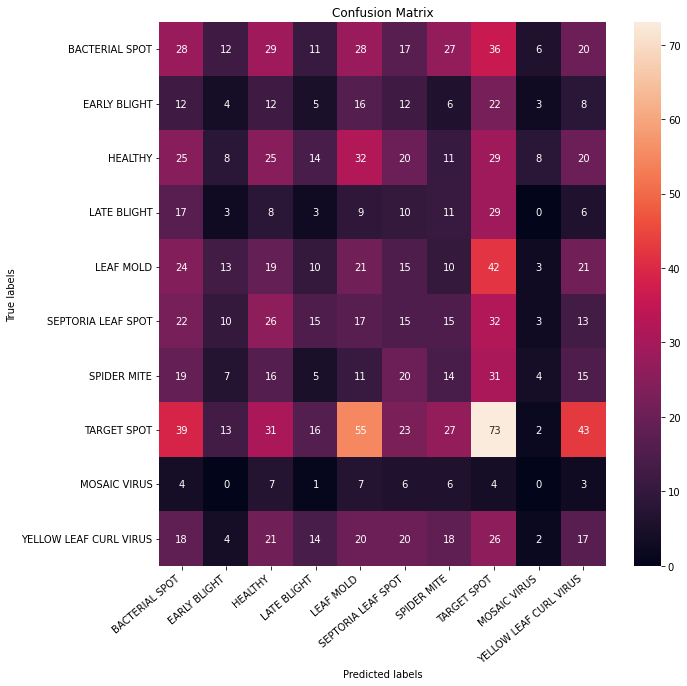

In [ ]:
import seaborn as sns
fig,ax= plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(order,rotation=40,ha='right'); ax.yaxis.set_ticklabels(order,rotation=360,ha='right');